In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from bisect import bisect
import seaborn as sns

from dandi.dandiapi import DandiAPIClient
from collections import defaultdict

In [2]:
sns.set_context("talk")

In [3]:
client = DandiAPIClient()
# to get information about embargoed -- need to authenticate
client.dandi_authenticate()

Please enter password for encrypted keyring:  ········


In [4]:
# ATM .get_dandisets() does not return embargoed. TODO: https://github.com/dandi/dandi-cli/issues/1413
# dandisets = list(client.get_dandisets())
# Meanwhile doing pagination manually
from dandi.dandiapi import RemoteDandiset
dandisets = []
for data in client.paginate("/dandisets/", params={"embargoed": True, "empty": False}):
    dandisets.append(RemoteDandiset.from_data(client, data))
print(f"# Dandisets: {len(dandisets)}")

# Dandisets: 399


In [5]:
species_replacement = {
    "Mus musculus - House mouse": "House mouse",
    "Rattus norvegicus - Norway rat": "Rat",
    "Brown rat": "Rat",
    "Rat; norway rat; rats; brown rat": "Rat",
    "Homo sapiens - Human": "Human",
    "Drosophila melanogaster - Fruit fly": "Fruit fly",
    "Cricetulus griseus - Cricetulus aureus": "Hamster",
    "Macaca nemestrina - Pig-tailed macaque": "Macaque",
    "Macaca nemestrina - Pigtail macaque": "Macaque",
    "Macaca nemestrina": "Macaque",
    "Procambarus clarkii - Red swamp crayfish": "Crayfish",
    "Caenorhabditis elegans": "C. elegans",
    "Oryctolagus cuniculus - Rabbits": "Rabbit",
    "Ooceraea biroi - Clonal raider ant": "Ant",
}

neurodata_type_map = dict(
    ecephys=["LFP", "Units", "ElectricalSeries"],
    ophys=["PlaneSegmentation", "TwoPhotonSeries", "ImageSegmentation"],
    icephys=["PatchClampSeries", "VoltageClampSeries", "CurrentClampSeries"],
    behav=['BehavioralEpochs', 'BehavioralEvents', 'BehavioralTimeSeries', 'Position'],
    eyetrack=['EyeTracking', 'PupilTracking'],
    optogen=['OptogeneticSeries'],
)

def is_nwb(metadata):
    return any(
        x['identifier'] == 'RRID:SCR_015242'
        for x in metadata['assetsSummary'].get('dataStandard', {})
    )

data = defaultdict(list)
all_variables_measured = []
for dandiset in dandisets:
    identifier = dandiset.identifier
    metadata = dandiset.get_raw_metadata()
    if not is_nwb(metadata) or not dandiset.draft_version.size:
        continue
    data["identifier"].append(identifier)
    data["created"].append(dandiset.created)
    data["size"].append(dandiset.draft_version.size)
    data["access"].append(str(dandiset.embargo_status).split('.')[-1])
    data["n_releases"].append(len([v for v in dandiset.get_versions() if v.identifier != 'draft']))
    if "species" in metadata["assetsSummary"] and len(metadata["assetsSummary"]["species"]):
        data["species"].append(metadata["assetsSummary"]["species"][0]["name"])
    else:
        data["species"].append(np.nan)
    
    variables_measured = metadata["assetsSummary"]["variableMeasured"]
    all_variables_measured.extend(variables_measured)
    for modality, ndtypes in neurodata_type_map.items():
        data[modality].append(
            any(x in ndtypes for x in variables_measured)
        )
    
    if "numberOfSubjects" in metadata["assetsSummary"]:
        data["numberOfSubjects"].append(metadata["assetsSummary"]["numberOfSubjects"])
    else:
        data["numberOfSubjects"].append(np.nan)
    
df = pd.DataFrame.from_dict(data)

species_unique1 = df["species"].unique()
for key, val in species_replacement.items():
    df["species"] = df["species"].replace(key, val)

species_unique2 = df["species"].unique()
# If there is both latin and then english through " - " - tak the latter
df["species"] = df["species"].apply(lambda x: isinstance(x, str) and x.rsplit(" - ", 1)[-1].strip() or x)

Other variables which were not associated with neurodata types yet:
Counter({'ElectrodeGroup': 179, 'ProcessingModule': 170, 'SpatialSeries': 69, 'OpticalChannel': 53, 'ImagingPlane': 53, 'CompassDirection': 35, 'CurrentClampStimulusSeries': 26, 'VoltageClampStimulusSeries': 20, 'SpikeEventSeries': 4, 'DecompositionSeries': 2, 'Spectrum': 1})


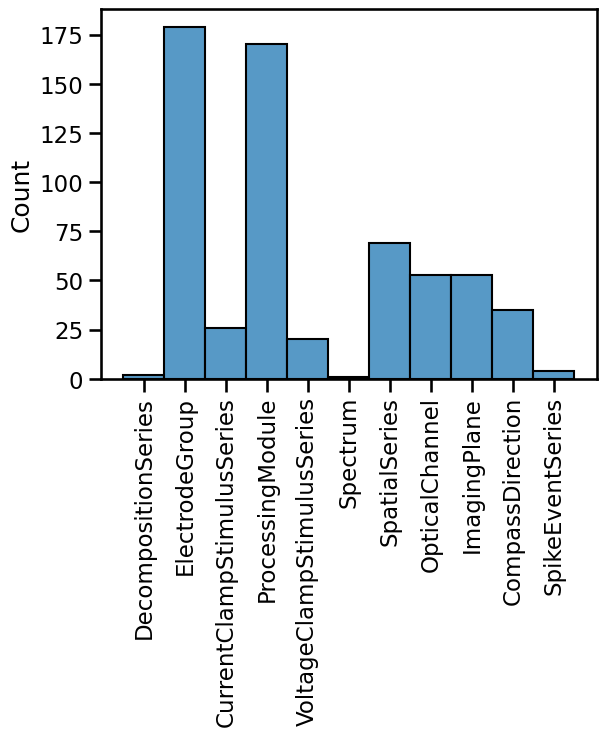

In [6]:
print("Other variables which were not associated with neurodata types yet:")
not_associated = set(all_variables_measured).difference(set(sum(neurodata_type_map.values(), [])))
all_variables_not_associated = [x for x in all_variables_measured if x in not_associated]
sns.histplot(all_variables_not_associated)
plt.xticks(rotation=90); 
from collections import Counter
print(Counter(all_variables_not_associated))

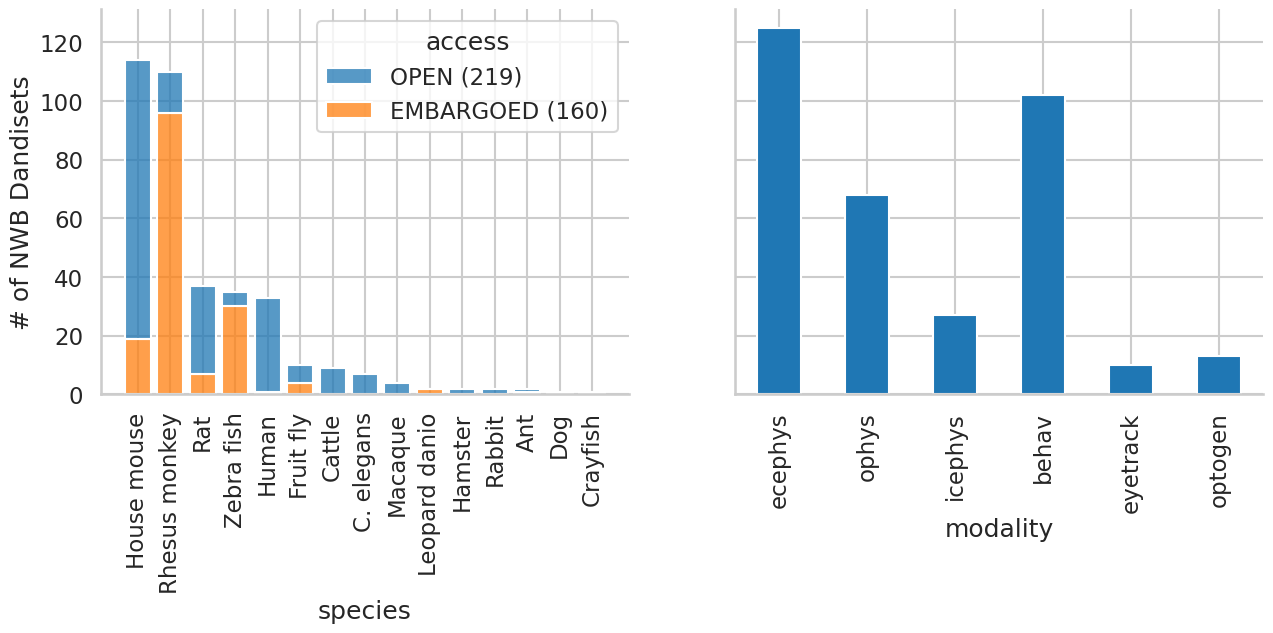

In [7]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

plt.axes(axs[0])

# Instead of this simple one, yoh decided to plot a complicated one depicting both
# OPEN and EMBARGOED across species
# ax = df["species"].value_counts().plot.bar()

# Count the occurrences of each category in 'species'
species_counts = df['species'].value_counts()
# Sort the index based on the counts, from highest to lowest
sorted_species = species_counts.index.tolist()
dfs = df.copy()
# Convert the 'species' column to a categorical type with the desired order
dfs['species'] = pd.Categorical(dfs['species'], categories=sorted_species, ordered=True)
dfs = dfs.sort_values('species')
ax = sns.histplot(data=dfs, x='species', hue='access', multiple='stack', shrink=0.8, discrete=True)
for text in ax.get_legend().texts:
    access = text.get_text()
    naccess = sum(df["access"] == access)
    text.set_text(f"{access} ({naccess})")
plt.xticks(rotation=90)  # Rotate labels if necessary
ax.set_ylabel("# of NWB Dandisets")
ax.set_xlabel("species")
sns.despine()

plt.axes(axs[1])
ax2 = df[list(neurodata_type_map)].sum().plot.bar()
ax2.set_xlabel("modality")
sns.despine()

if False:  # to plot embargoed stats separately as well, but numbers too high - squash prior ones
    plt.axes(axs[2])
    # Retrieve the current default color palette from seaborn
    colors = sns.color_palette()
    # Get value counts and sort the index if you want a specific order
    access_counts = df["access"].value_counts().sort_index()
    # Define colors in the order of the bars. Adjust based on your actual data order.
    # For example, if "OPEN" comes first, followed by "EMBARGOED", assign colors accordingly.
    colors = [colors[0] if x == 'OPEN' else colors[1] for x in access_counts.index]
    ax = access_counts.plot.bar(color=colors)
    # ax = df["access"].value_counts().plot.bar()
    ax.set_ylabel("# of NWB Dandisets")
    ax.set_xlabel("access")
    sns.despine()

ax.figure.savefig("species-modality-access.png", bbox_inches="tight")

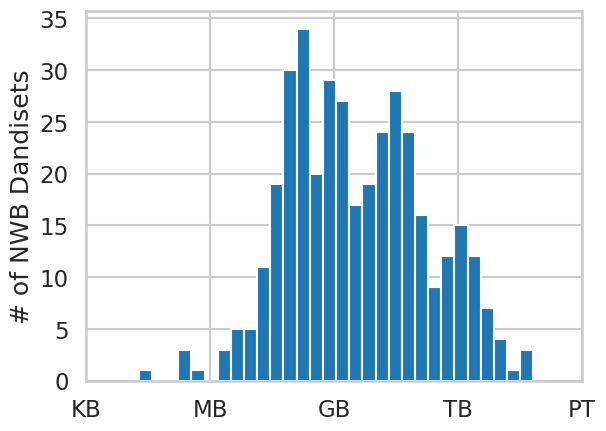

In [8]:
logsize = np.log10(df["size"])
#logsize[logsize < 0] = np.nan

ax = logsize.plot.hist(bins=30)
ax.set_xticks([3, 6, 9, 12, 15])
ax.set_ylabel("# of NWB Dandisets")
ax.set_xticklabels(["KB", "MB", "GB", "TB", "PT"])
ax.figure.savefig("size.png", bbox_inches="tight")

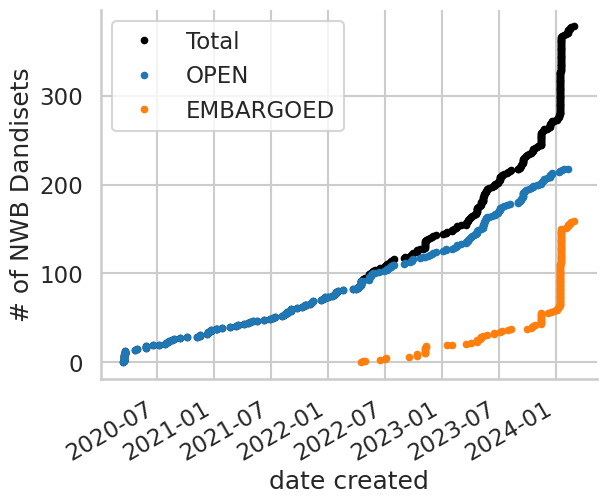

In [9]:
fig, ax = plt.subplots()

axes = {}
axes['Total'] = ax.plot(df['created'], np.arange(len(df)), 'k.')
access_types = list(df['access'].unique())
for access in access_types:
    df_ = df[df['access'] == access]
    axes[access] = ax.plot(df_['created'], np.arange(len(df_)), '.')
ax.legend(["Total"] + access_types)

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel('# of NWB Dandisets')
ax.set_xlabel("date created")
sns.despine()
ax.figure.savefig("date.png", bbox_inches="tight")

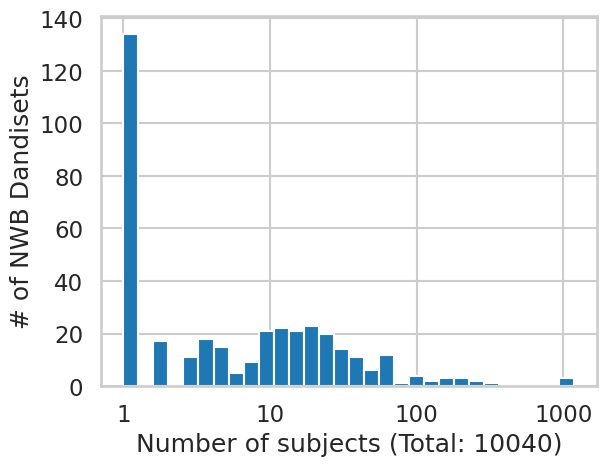

In [10]:
lognum = np.log10(df["numberOfSubjects"])

ax = lognum.plot.hist(bins=30)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([1, 10, 100, 1000])
ax.set_ylabel('# of NWB Dandisets')

ax.set_xlabel(f"Number of subjects (Total: {df['numberOfSubjects'].sum().astype(int)})")
ax.figure.savefig("subjects.png", bbox_inches="tight")